# TRAINING PIPELINE

In [1]:
#pip install -r ../requisitos.txt --no-deps

## Trackeo Modelo

Para esto usaremos el autolog, que es la manera más simple de traquear los modelos sin tener previo conocimiento del problema o sin tener estandares aun definidos.

La libreria mlflow puede autoregistrar muiltiples parametros de la ejecución de los modelos:

Metrics
Parameters
Model Signature
Artifacts
Dataset - ej. tensorflow.data.Dataset





y el autolog soporta las librerias más utilizadas:

    Fastai
    Gluon
    Keras
    LightGBM
    PyTorch
    Scikit-learn
    Spark
    Statsmodels
    XGBoost

In [2]:
## Para logear experimentos
import mlflow
import logging

# Logea todos los modelos que aparezcan
mlflow.autolog() 

#Aca solo logramos los modelos de pytorch
# mlflow.pytorch.autolog()

#Aca desactivamos logeo de sklearn y activamos todo el resto.
# mlflow.sklearn.autolog(disable=True)
# mlflow.autolog()

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


## Import

In [3]:
# Importar módulos necesarios
import pandas as pd
import numpy as np
import math
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import TargetEncoder
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report
from sklearn.model_selection import KFold


import pickle
import sii_utils

import factor_analyzer as fact

sii_utils.suppress_warnings('pw')

2024/03/14 19:30:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [4]:
import sii_utils

#import importlib
#importlib.reload(sii_utils)

## Cargar Configuraciones & dataset

In [5]:
import yaml


import datetime
today = datetime.date.today()

if __name__ == "__main__":
    mlflow.set_experiment("Modelo Riesgo-srios-"+str(today))
    mlflow.set_tags(tags={"version": "v1", "priority": "P1"})
    
    try:
        with open('../config_file.yml', 'r') as file:
            cfg = yaml.safe_load(file)
        cfg
    except Exception as e:
         logger.exception("No cargo la configuracion inicial. Error: %s", e)
    # Split the data into training and test sets. (0.75, 0.25)

mlflow.start_run(nested=True)


2024/03/14 19:30:30 INFO mlflow.tracking.fluent: Experiment with name 'Modelo Riesgo-srios-2024-03-14' does not exist. Creating a new experiment.


<ActiveRun: >

In [6]:
#mlflow.end_run()
cfg

{'path': {'Home': '../',
  'Bronze': 'data/Bronze/',
  'Silver': 'data/Silver/',
  'Gold': 'data/Gold/',
  'Artefactos': 'artefactos/'},
 'data_files': {'Bronze': 'GOVMS_BA_PRED_ANON.tab',
  'Silver': 'Silver_data.csv',
  'Gold': 'Gold_data.csv'},
 'model_files': {'Log_metrics': 'Log_metrics.txt', 'Model_name': 'Model.pkl'}}

In [7]:
### Carga el conjunto de datos desde un archivo CSV 

## Leer archivo con los tipos de variables
path_df_type = Path(cfg['path']['Home'], cfg['path']['Silver'], 'Silver_DJ_preprocessed_var_types.csv')
print(f'Ruta tipo de variables: {path_df_type}')
dtypes_df = pd.read_csv(path_df_type, sep = ';')
dtypes_df = dict(zip(dtypes_df['Variable'], dtypes_df['Tipo']))


# Construir la ruta al archivo CSV 
path_datasilver = Path(cfg['path']['Home'], cfg['path']['Silver'], 'Silver_DJ_preprocessed.csv')
# Imprimir la ruta del archivo
print(f'Ruta del dataset: {path_datasilver}')

# Cargar el DataFrame desde el archivo CSV utilizando pandas
df = pd.read_csv(path_datasilver, sep=';', dtype = dtypes_df)


# Aplicar la función de conversión de tipos del módulo sii_utils -> reemplazado por parametro dtype 
#df = sii_utils._convert_types(df, filename=str(path_df_type))

# Imprimir la forma del DataFrame
print(f'Dimensionalidad del DataFrame: {df.shape}')

# Mostrar las primeras 4 filas del DataFrame
print('Primeras 4 filas del DataFrame:')
display(df.head(4))

Ruta tipo de variables: ../data/Silver/Silver_DJ_preprocessed_var_types.csv
Ruta del dataset: ../data/Silver/Silver_DJ_preprocessed.csv
Dimensionalidad del DataFrame: (4126, 64)
Primeras 4 filas del DataFrame:


,CONT_RUT,CONT_DV,campo_93,campo_57,campo_61,campo_85,campo_94,campo_4,campo_1,campo_83,...,campo_91,campo_76,campo_72,campo_97,campo_73,campo_79,campo_84,campo_104,campo_60_cat,Presenta_union
0,72,3,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,NULO,-999.0,...,-999.0,-999.0,-999.0,NULO,-999.0,-999.0,-999.0,0.0,2,0
1,913,4,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,NULO,-999.0,...,-999.0,-999.0,-999.0,NULO,-999.0,-999.0,-999.0,0.0,2,0
2,1059,7,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,NULO,-999.0,...,-999.0,-999.0,-999.0,NULO,-999.0,-999.0,-999.0,0.0,2,0
3,1258,7,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,NULO,-999.0,...,-999.0,-999.0,-999.0,NULO,-999.0,-999.0,-999.0,0.0,2,0


## Definir Target

In [8]:
target_dj = '1926'

target_cols = {
'1948': ['campo_4','campo_9'],
'1947': ['campo_3','campo_8'],
'1847': ['campo_1','campo_6'],
'1926': ['campo_2','campo_7'],
}

ALL_VO=['campo_4','campo_9','campo_3','campo_8','campo_1','campo_6','campo_2','campo_7']
drop_col = list(set(ALL_VO)-set(target_cols[target_dj]))
drop_col = drop_col+["campo_58","campo_52","campo_60",'campo_57']
df.drop(columns = drop_col, inplace=True)
print(f'DataFrame shape {df.shape}')
###

df['Y'] = df[target_cols[target_dj][0]]
df = df.loc[df['Y'] != 'NULO',:]
df['Y'] = df['Y'].replace('NULO', 0).astype(float).astype(int) ### Consultar si esto tiene sentido de negocio

df.drop(columns = target_cols[target_dj], inplace = True)
print(f'DataFrame shape {df.shape}')

dirs = ['Scaler', 'Categorias', 'ReduccionDim','TargetEncoder', 'Modelo']
for d in dirs:
    path_=Path(cfg['path']['Home'],cfg['path']['Artefactos'], 'DRJ'+target_dj,d)
    sii_utils.mkdir_if_not_exists(path_)


DataFrame shape (4126, 54)
DataFrame shape (289, 53)
Directory '../artefactos/DRJ1926/Scaler' already exists.
Directory '../artefactos/DRJ1926/Categorias' already exists.
Directory '../artefactos/DRJ1926/ReduccionDim' already exists.
Directory '../artefactos/DRJ1926/TargetEncoder' already exists.
Directory '../artefactos/DRJ1926/Modelo' already exists.


In [9]:
df['Y'].value_counts()

0    212
1     77
Name: Y, dtype: int64

## Analisis Descriptivo

In [10]:
sii_utils.Descriptivo(df,'SII_TEST')

Se ha creado un descriptivo de los datos


In [11]:
df["campo_83_indmag"],df["campo_83_indpos"]=sii_utils.Transformacion_valoresnegativos(df["campo_83"])
df["campo_95_indmag"],df["campo_95_indpos"]=sii_utils.Transformacion_valoresnegativos(df["campo_95"])

inpos_names=['campo_83_indpos','campo_95_indpos']
df[inpos_names]= df[inpos_names].astype('str')

#df.drop(columns = ['campo_83','campo_95'], inplace = True) # confirmar si es realmente necesario

In [12]:
df.isna().sum().to_frame('N').sort_values('N', ascending=False).head(3)

,N
CONT_RUT,0
CONT_DV,0
campo_93,0


## Train/Test Split

In [13]:
data = sii_utils.split_data(df,'Y')

print("Train dataset {:.3f}".format(data['train']['y'].mean()))
print("Test  dataset {:.3f}".format(data['test']['y'].mean()))


seleccionadas = list(df.columns)
keys_to_drop = ['CONT_RUT','CONT_DV','Y']

for k in keys_to_drop:
    seleccionadas.remove(k)
print(f"Atributos Iniciales {len(seleccionadas)}")

Train dataset 0.282
Test  dataset 0.230
Atributos Iniciales 54


## separar dataset cat/num

In [14]:
# Extrae columnas de tipo 'object' (categóricas) y de tipo numérico del DataFrame original
df_col_cat = df.select_dtypes(include=['object']).columns.to_list()
df_col_num = df.select_dtypes(include=['number']).columns.to_list()

# Intersecta las columnas extraídas con la lista de columnas seleccionadas (seleccionadas)
df_col_cat = list(set(df_col_cat) & set(seleccionadas))
df_col_num = list(set(df_col_num) & set(seleccionadas))


print("Numero  de variables categoricas",len(df_col_cat))
print("Numero  de variables continuas",len(df_col_num))

Numero  de variables categoricas 17
Numero  de variables continuas 37


## Transformacion y estandarizacion de las variables

### sign*log10(x)

In [15]:
## Crear variables de sign*log(x)
for col in df_col_num:
    data['train']['X'][col+'_Log10'] = data['train']['X'][col].apply(lambda x: np.log(x+1) if x > 0 else (-1*np.log(np.abs(x)+1) if x < 0 else 0))
    data['test']['X'][col+'_Log10']  = data['test']['X'][col].apply(lambda x: np.log(x+1) if x > 0 else (-1*np.log(np.abs(x)+1) if x < 0 else 0))

# update_df_col_num and seleccionadas
seleccionadas = seleccionadas + [x+'_Log10' for x in df_col_num]
## se modifica luego de seleccionadas para no duplicar nombres
df_col_num    = df_col_num + [x+'_Log10' for x in df_col_num]


print(f"#cols en dataframe train: {data['train']['X'].shape[1]} - test: {data['test']['X'].shape[1]}")
print(f"#cols  seleccionadas categoricas: {len(df_col_cat)}")
print(f"#cols en seleccionadas : {len(seleccionadas)}")

#cols en dataframe train: 93 - test: 93
#cols  seleccionadas categoricas: 17
#cols en seleccionadas : 91


### StandarScaler

In [16]:
# StandarScaler
for col in df_col_num:

    scaler=StandardScaler()
    #entrenar scaler en conjunto de entrenamiento
    data['train']['X'][col+'_sc'] = scaler.fit_transform(data['train']['X'][[col]].values)
    #aplicar scaler en conjunto de entrenamiento
    data['test']['X'][col+'_sc'] = scaler.transform(data['test']['X'][[col]].values)

    #guardar scaler
    path_scaler=Path(cfg['path']['Home'],cfg['path']['Artefactos'], 'DRJ'+target_dj,'Scaler',f'SII_scaler_{col}.pkl')
    pickle.dump(scaler, open(path_scaler,'wb'))


# update_df_col_num and seleccionadas
seleccionadas = seleccionadas + [x+'_sc' for x in df_col_num]
## se modifica luego de seleccionadas para no duplicar nombres
df_col_num    = df_col_num + [x+'_sc' for x in df_col_num]


print(f"#cols en dataframe train: {data['train']['X'].shape[1]} - test: {data['test']['X'].shape[1]}")
print(f"#cols  seleccionadas categoricas: {len(df_col_cat)}")
print(f"#cols en seleccionadas : {len(seleccionadas)}")

#cols en dataframe train: 167 - test: 167
#cols  seleccionadas categoricas: 17
#cols en seleccionadas : 165


### Reducir categorias poco frecuentes

In [17]:
## reducir categorias poco frecuentes
for col in df_col_cat:
    cat_freq = (data['train']['X'][[col]].value_counts().to_frame('pct')/data['train']['X'].shape[0]).reset_index()
    col_cat = cat_freq.loc[cat_freq['pct']> 0.02,col].to_list()

    #guardar categorias
    path_cat=Path(cfg['path']['Home'],cfg['path']['Artefactos'], 'DRJ'+target_dj,'Categorias',f'SII_cat_{col}.pkl')
    pickle.dump(scaler, open(path_cat,'wb'))

    #imputar aquellas categorias con baja frecuencia - conjunto de entrenamiento
    data['train']['X'].loc[~data['train']['X'][col].isin(col_cat), col] = 'BAJA_FRECUENCIA'
    #imputar aquellas categorias con baja frecuencia - conjunto de prueba
    data['test']['X'].loc[~data['test']['X'][col].isin(col_cat), col] = 'BAJA_FRECUENCIA'

### TargetEnconder

In [18]:
# Aplicar TargetEncoder a las columnas numéricas en el conjunto de entrenamiento
for col in df_col_cat:
    # Definir la transformación TargetEncoder
    target_encoder = TargetEncoder(target_type='binary')

    # Entrenar el transformador en el conjunto de entrenamiento
    # fit(X, y).transform(X) does not equal fit_transform(X, y) because a cross fitting scheme is used in fit_transform for encoding
    target_encoder.fit(data['train']['X'][[col]], data['train']['y'])
    
    # Aplicar la transformación al conjunto de entrenamiento
    data['train']['X'][col + '_targetEncoder'] = target_encoder.transform(data['train']['X'][[col]])
    
    # Aplicar la transformación al conjunto de prueba
    data['test']['X'][col + '_targetEncoder'] = target_encoder.transform(data['test']['X'][[col]])

    #guardar encoder
    path_cat=Path(cfg['path']['Home'],cfg['path']['Artefactos'], 'DRJ'+target_dj,'TargetEncoder',f'SII_targetencoder_{col}.pkl')
    pickle.dump(scaler, open(path_cat,'wb'))


# update_df_col_num and seleccionadas
seleccionadas = seleccionadas + [x+'_targetEncoder' for x in df_col_cat]
## se modifica luego de seleccionadas para no duplicar nombres
df_col_num    = df_col_num + [x+'_targetEncoder' for x in df_col_cat]

print(f"#cols en dataframe train: {data['train']['X'].shape[1]} - test: {data['test']['X'].shape[1]}")
print(f"#cols  seleccionadas categoricas: {len(df_col_cat)}")
print(f"#cols en seleccionadas : {len(seleccionadas)}")

#cols en dataframe train: 184 - test: 184
#cols  seleccionadas categoricas: 17
#cols en seleccionadas : 182


### Reducir Dimensionalidad

In [20]:
djr1847_diccionario_pca={
'n_components':9,
'variables_pca':['campo_80', 'campo_68','campo_83_indmag','campo_74','campo_95_indmag', 'campo_39','campo_86', 'campo_92','campo_62',
       'campo_61','campo_75','campo_73', 'campo_84','campo_87', 'campo_85','campo_94','campo_93','campo_91', 'campo_77','campo_76', 'campo_22',
       'campo_26','campo_23','campo_78','campo_79', 'campo_70','campo_71', 'campo_72','campo_69','campo_35','campo_37',
       'campo_101']}

PCA_use=djr1847_diccionario_pca

### PCA

In [21]:
##PCA
pca_col       = list(set(PCA_use['variables_pca'])&set(seleccionadas))
pca_components= PCA_use['n_components']

#PCA
pca = PCA(n_components=pca_components)
pca.fit(data['train']['X'][pca_col])

pca_train  = pca.transform(data['train']['X'][pca_col])
pca_test   = pca.transform(data['test']['X'][pca_col])
col_pca=[f'PCA_comp_{x+1}' for x in range(pca_components)]

data['train']['X'] = pd.concat([data['train']['X'].reset_index(drop=True), pd.DataFrame(data = pca_train, columns = col_pca).reset_index(drop=True)],  axis = 1)
data['test']['X']  = pd.concat([data['test']['X'].reset_index(drop=True), pd.DataFrame(data = pca_test, columns = col_pca).reset_index(drop=True)],  axis = 1)
   
## Save PCA
path_pca=Path(cfg['path']['Home'],cfg['path']['Artefactos'], 'DRJ'+target_dj,'ReduccionDim',f'SII_pca.pkl')
pickle.dump(pca, open(path_pca,'wb'))

# update_df_col_num and seleccionadas
seleccionadas = seleccionadas + col_pca
## se modifica luego de seleccionadas para no duplicar nombres
df_col_num    = df_col_num + col_pca

print(f"#cols en dataframe train: {data['train']['X'].shape[1]} - test: {data['test']['X'].shape[1]}")
print(f"#cols  seleccionadas categoricas: {len(df_col_cat)}")
print(f"#cols en seleccionadas : {len(seleccionadas)}")

2024/03/13 12:47:08 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/03/13 12:47:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/03/13 12:47:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/cdsw/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


#cols en dataframe train: 193 - test: 193
#cols  seleccionadas categoricas: 17
#cols en seleccionadas : 191


## Seleccionadas para entrenamiento

In [22]:
##Conservar lsolo continueas
seleccionadas = list(set(seleccionadas)-set(df_col_cat))

print(f"#cols en dataframe train: {data['train']['X'].shape[1]} - test: {data['test']['X'].shape[1]}")
print(f"#cols en seleccionadas : {len(seleccionadas)}")

mlflow.log_param("ColTot", data['train']['X'].shape[1])
mlflow.log_param("ColSel", len(seleccionadas))


#cols en dataframe train: 193 - test: 193
#cols en seleccionadas : 174


174

In [23]:
#mlflow.sklearn.log_model(PCA,"PCA ANALISIS")

# AUTOML

In [24]:
### AUTO ML - ALL FEATURES
score_metrics=sii_utils.Score_metrics()
dict_models=sii_utils.Dict_models()
dfresumen_automl=pd.DataFrame()
cv=KFold(n_splits=4, random_state=42, shuffle=True)

dic_modelstraining={}
for model in dict_models:
    print(model)
    df,modelfit = sii_utils.Reporte(dict_models[model], data['train']['X'][seleccionadas],data['train']['y'], name=model, cv=cv, dict_scoring=score_metrics)

    dfresumen_automl=pd.concat([dfresumen_automl,df])
    dic_modelstraining[model]=modelfit
    #mlflow.sklearn.log_model(dict_models[model],model)
    

resumen=dfresumen_automl[["Modelo","Feature","test_prec_mean","test_acc_mean","test_recall_mean", "test_f1-score_mean",'test_roc_auc_mean']].sort_values(by=["test_roc_auc_mean"], ascending=False)
resumen

SVM


/home/cdsw/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/cdsw/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/cdsw/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/cdsw/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SGDClassifier


/home/cdsw/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cdsw/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cdsw/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic


/home/cdsw/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cdsw/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Random_forest


,Modelo,Feature,test_prec_mean,test_acc_mean,test_recall_mean,test_f1-score_mean,test_roc_auc_mean
0,Random_forest,features,0.70098,0.791961,0.507652,0.57182,0.705545
0,Logistic,features,0.37598,0.698529,0.453139,0.409527,0.63007
0,SGDClassifier,features,0.171821,0.580882,0.483333,0.253502,0.530678
0,SVM,features,0.19217,0.544902,0.472403,0.260227,0.519321


In [25]:
## Best Model
best_model = resumen.loc[resumen['test_roc_auc_mean']==resumen['test_roc_auc_mean'].max(), ['Modelo', 'test_roc_auc_mean']].values[0]
print('El mejor modelo es {} con un AUC de {:.2f}'.format(best_model[0], best_model[1]))

El mejor modelo es Random_forest con un AUC de 0.71


In [26]:
best_modelname='Random_forest'
best_model=dic_modelstraining[best_modelname]
model=sii_utils.Train_model(data,seleccionadas, best_model,'DRJ'+target_dj,best_modelname)

#####  METRICAS CONJUNTO DE TRAIN
y_pred    = model.predict_proba(data['train']['X'][seleccionadas])[:,1]
ev_train = sii_utils.evaluate_classification(data['train']['y'],y_pred)
print("Desempeño del modelo AUC: {:.2f} \t KS: {:.2f}".format(ev_train[0],ev_train[1]))

#####  METRICAS CONJUNTO DE TEST
y_pred    = model.predict_proba(data['test']['X'][seleccionadas])[:,1]
ev_test = sii_utils.evaluate_classification(data['test']['y'],y_pred)
print("Desempeño del modelo AUC: {:.2f} \t KS: {:.2f}".format(ev_test[0],ev_test[1]))

Modelo Random_forest con un Score de 0.80
Modelo Guardado en ../artefactos/DRJ1926/Modelo/modelo_Random_forest.pkl
Desempeño del modelo AUC: 1.00 	 KS: 1.00
Desempeño del modelo AUC: 0.72 	 KS: 0.38


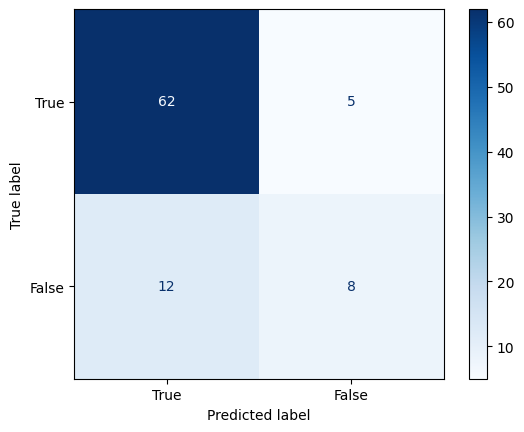

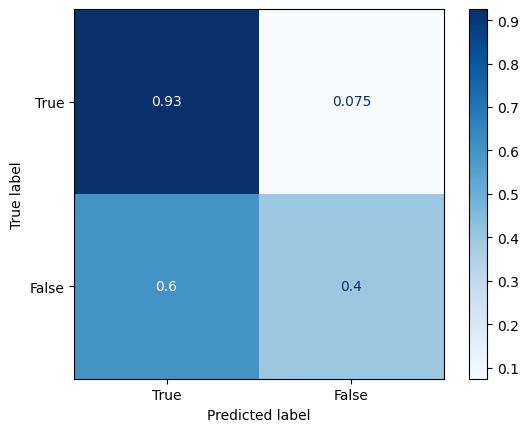

In [27]:
y_pred = model.predict(data['test']['X'][seleccionadas])
sii_utils.Matriz_confusion(data['test']['y'],y_pred)
sii_utils.Matriz_confusion_per(data['test']['y'],y_pred)

In [28]:
target_names=['Presenta','No presenta']

model_report=classification_report(data['test']['y'],y_pred, target_names=target_names)
print(model_report)

              precision    recall  f1-score   support

    Presenta       0.84      0.93      0.88        67
 No presenta       0.62      0.40      0.48        20

    accuracy                           0.80        87
   macro avg       0.73      0.66      0.68        87
weighted avg       0.79      0.80      0.79        87



In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4, 4))

feat_importances = pd.Series(best_model.feature_importances_, index=seleccionadas)
print(len(seleccionadas))
feat_importances.nlargest(5).plot(kind='barh')

174


<Axes: >

# Feature Selection

## Seleccion Bivariada

In [30]:
## Get Features Statistics
## Por ahora solo toma variables numericas
predVar, seleccionadas = sii_utils.GetFeaturesStatistics(data, seleccionadas)
predVar.sort_values('AUC', ascending=False, inplace = True)
print(len(seleccionadas))

174


In [31]:
### Filtrar Seleccionadas
predVar = predVar.loc[predVar['AUC']>=0.53,:]
print(predVar.shape)
predVar = predVar.loc[predVar['KS']>=0.05,:]
print(predVar.shape)
seleccionadas = list(predVar['Feature'].values)
print(len(seleccionadas))

(158, 3)
(158, 3)
158


## Incluir PCA

In [32]:
INCL_PCA = 'SI'
if INCL_PCA == 'SI':
    print(len(seleccionadas))
if INCL_PCA == 'NO':
    predVar = predVar.loc[~predVar['Feature'].str.contains('PCA'),:]
if INCL_PCA == 'SOLO_PCA':
    predVar = predVar.loc[predVar['Feature'].str.contains('PCA'),:]

seleccionadas = list(predVar['Feature'].values)
print(len(seleccionadas))

158
158


## Seleccion Multivariada

In [33]:
## Seleccion por correlacion
predVar, seleccionadas= sii_utils.SelCorrGlobal(data['train']['X'], predVar,  corThr = 0.75)
print("seleccionadas: ",len(seleccionadas))

seleccionadas:  41


In [34]:
#seleccion por modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### parametros de grid search en seccion de parametros
parameters = {'n_estimators':[10, 20, 50, 100],
              'max_depth':[3, 4, 5],
              'min_samples_leaf': [6, 8]
             }

clf = RandomForestClassifier()
clf = GridSearchCV(clf, parameters, cv=3, verbose = 0, n_jobs = 8)
clf.fit(data['train']['X'][seleccionadas], data['train']['y'])
clf_best =  clf.best_estimator_
print(clf_best)

2024/03/13 12:48:22 INFO mlflow.sklearn.utils: Logging the 5 best runs, 19 runs will be omitted.


RandomForestClassifier(max_depth=3, min_samples_leaf=6, n_estimators=20)


In [35]:
y_pred = clf_best.predict_proba(data['test']['X'][seleccionadas])[:,1]

ev = sii_utils. evaluate_classification(data['test']['y'],y_pred)
print("Desempeño del modelo AUC: {:.2f} \t KS: {:.2f}".format(ev[0],ev[1]))


feature_imp = pd.DataFrame({'Feature':seleccionadas, 'Value':clf_best.feature_importances_}).sort_values('Value', ascending = False)
feature_imp['cumValue'] = feature_imp['Value'].cumsum()
feature_imp['cumValue'] = feature_imp['cumValue']/feature_imp['Value'].sum()
feature_imp.sort_values('cumValue', ascending = True, inplace = True)
feature_imp.head(5)

Desempeño del modelo AUC: 0.76 	 KS: 0.42


,Feature,Value,cumValue
3,campo_84_Log10_sc,0.198932,0.198932
2,campo_26_Log10_sc,0.167566,0.366497
5,campo_22,0.124319,0.490817
0,PCA_comp_1,0.108339,0.599155
4,campo_83_Log10,0.056040,0.655195


In [36]:
## Seleccionar aquellos atributos que acumulan el 95% de la importancia
ft_imp_set = feature_imp.loc[feature_imp['cumValue']<=.95,'Feature'].to_list()
predVar = predVar.loc[predVar['Feature'].isin(ft_imp_set),:]
print(predVar.shape)
seleccionadas = list(predVar['Feature'].values)
print(len(seleccionadas))

run_id = mlflow.last_active_run().info.run_id
print(f"Logged data and model in run {run_id}")

(19, 3)
19
Logged data and model in run exra-s71h-uoz4-lnkb


# Modelo Final

In [37]:
from mlflow.models import infer_signature, set_signature

mlflow.log_param("name", "RandomForest_Best_CoderHub")



clf_final = RandomForestClassifier(n_estimators=clf.best_params_['n_estimators'],
                                min_samples_leaf = clf.best_params_['min_samples_leaf'],
                                max_depth = clf.best_params_['max_depth']
                                )

clf_final.fit(data['train']['X'][seleccionadas], data['train']['y'])

mlflow.sklearn.log_model(clf_final, 'Best_Model_Coderhub')

#####  METRICAS CONJUNTO DE TRAIN
y_pred    = clf_final.predict_proba(data['train']['X'][seleccionadas])[:,1]
ev_train = sii_utils.evaluate_classification(data['train']['y'],y_pred)
print("Desempeño del modelo AUC: {:.2f} \t KS: {:.2f}".format(ev_train[0],ev_train[1]))

#####  METRICAS CONJUNTO DE TEST
y_pred    = clf_final.predict_proba(data['test']['X'][seleccionadas])[:,1]
ev_test = sii_utils.evaluate_classification(data['test']['y'],y_pred)
print("Desempeño del modelo AUC: {:.2f} \t KS: {:.2f}".format(ev_test[0],ev_test[1]))
print(len(seleccionadas))


run_id = mlflow.last_active_run().info.run_id
print(f"Logged data and model in run {run_id}")



Desempeño del modelo AUC: 0.93 	 KS: 0.74
Desempeño del modelo AUC: 0.78 	 KS: 0.43
19
Logged data and model in run exra-s71h-uoz4-lnkb


# Interpretabilidad

In [38]:
#pip install ipywidgets

In [39]:
import shap
exp = shap.TreeExplainer(clf_final) #Explainer
shap_values = exp.shap_values(data['test']['X'][seleccionadas])  #Calculate SHAP values

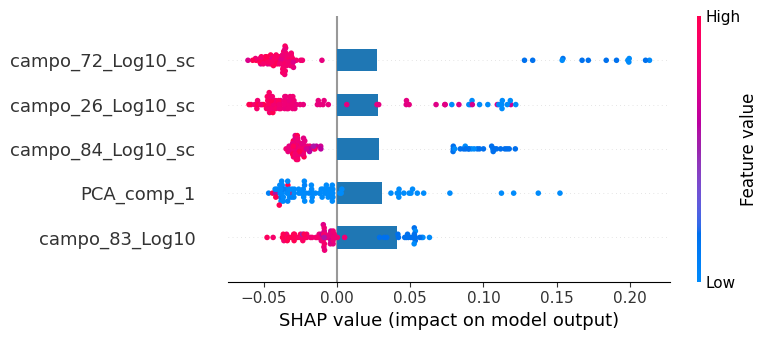

In [40]:
shap.summary_plot(shap_values[1], data['test']['X'][seleccionadas], max_display = 5)

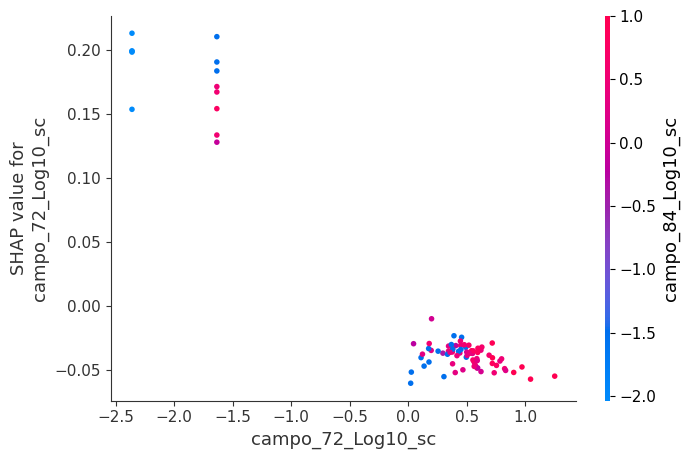

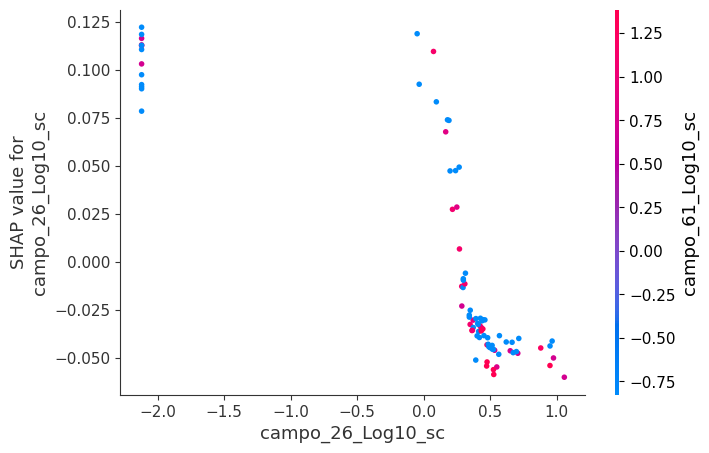

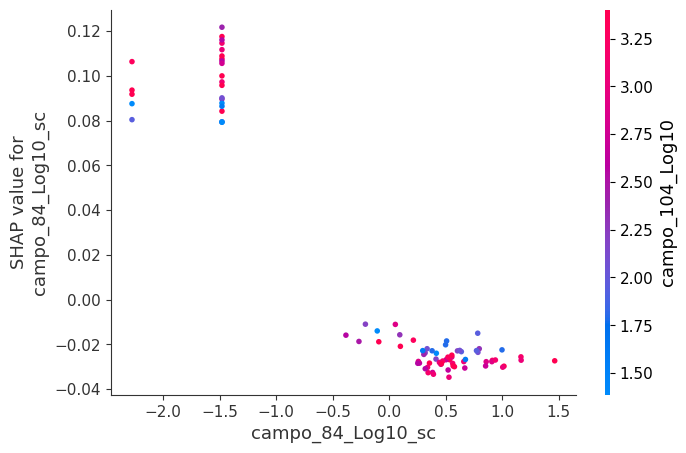

In [41]:
for i in range(3):
    shap.dependence_plot(f"rank({i})", shap_values[1], data['test']['X'][seleccionadas])

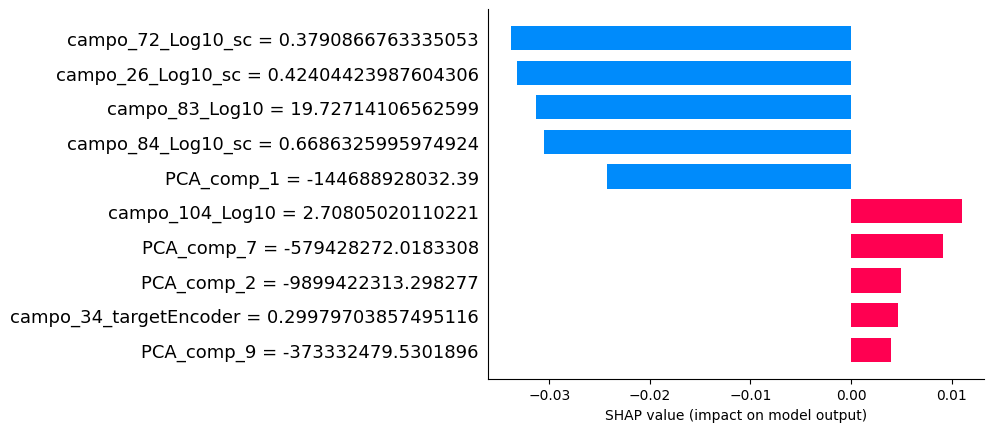

In [42]:
#search_rut = 1920229
#search_id = data['test']['X'].loc[data['test']['X']['CONT_RUT'] == search_rut,:].index[0]
search_id = 0
shap.bar_plot(shap_values[1][search_id],features =data['test']['X'][seleccionadas].iloc[search_id,:] ,feature_names =seleccionadas, max_display=10 )

Genero Data de Prueba

In [43]:
mlflow.end_run()

In [48]:
data['train']['X'][seleccionadas].head().to_csv("QA_data_applicacion_"+str(run_id)+".csv",index=False)

Se debe guardar la carpeta donde el MLFLOW guarda todos los artefactos y modelos.
Usualmente esto esta en: /home/cdsw/.experiments/
Eso se genera con el siguente commando

In [51]:
experiments_tar_name = "experiments_"+str(run_id)+".tar"

In [58]:
!tar cvf {experiments_tar_name} -C /home/cdsw/ .experiments/ 

.experiments/
.experiments/swka-66bx-zw25-rt4n/
.experiments/swka-66bx-zw25-rt4n/smcm-xw99-bplz-53a6/
.experiments/swka-66bx-zw25-rt4n/smcm-xw99-bplz-53a6/artifacts/
.experiments/swka-66bx-zw25-rt4n/smcm-xw99-bplz-53a6/artifacts/estimator.html
.experiments/swka-66bx-zw25-rt4n/smcm-xw99-bplz-53a6/artifacts/model/
.experiments/swka-66bx-zw25-rt4n/smcm-xw99-bplz-53a6/artifacts/model/python_env.yaml
.experiments/swka-66bx-zw25-rt4n/smcm-xw99-bplz-53a6/artifacts/model/requirements.txt
.experiments/swka-66bx-zw25-rt4n/smcm-xw99-bplz-53a6/artifacts/model/conda.yaml
.experiments/swka-66bx-zw25-rt4n/smcm-xw99-bplz-53a6/artifacts/model/MLmodel
.experiments/swka-66bx-zw25-rt4n/smcm-xw99-bplz-53a6/artifacts/model/model.pkl
.experiments/swka-66bx-zw25-rt4n/uakf-c0sw-szf4-tea3/
.experiments/swka-66bx-zw25-rt4n/uakf-c0sw-szf4-tea3/artifacts/
.experiments/swka-66bx-zw25-rt4n/uakf-c0sw-szf4-tea3/artifacts/estimator.html
.experiments/swka-66bx-zw25-rt4n/uakf-c0sw-szf4-tea3/artifacts/model/
.experiments/

Genero requisitos.txt

In [ ]:
pip freeze > requisitos.txt